**Multi Class Classification of text messages using Bi-directional LSTM for Online Abuse Detection in social media**


# Importing



In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split



In [ ]:
#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")
eng_stopwords = STOPWORDS
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

# Exploratory data analysis

In [ ]:
#importing the dataset
train=pd.read_csv("/content/drive/My Drive/toxic/train.csv")

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train = train.drop(labels='id', axis=1)

In [ ]:
train.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#checking class imbalance
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  149012
Total tags = 19804


In [ ]:
#checking for missing values
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset


NameError: ignored

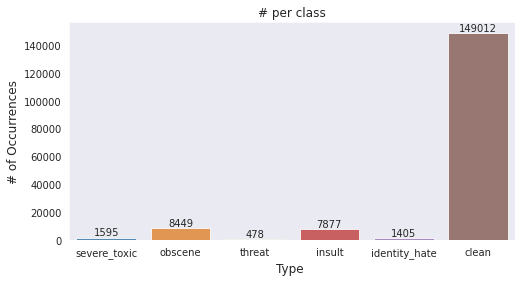

In [ ]:
#Visualizing Number of occurrences per class
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The toxicity is not evenly spread across the classes. There are multiple tags associated with each comment. For example a comment can be classified as both toxic and insult.


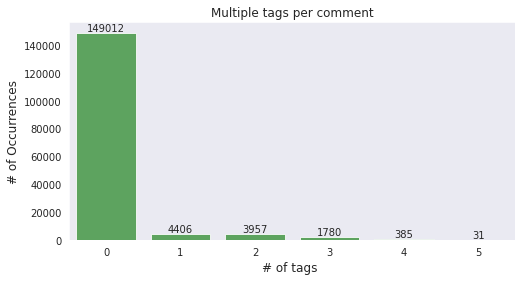

In [ ]:
#Plotting multiple tags

x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

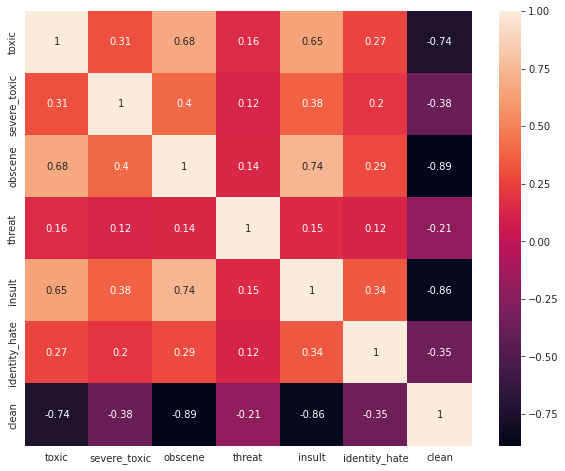

In [ ]:
temp_df=train.iloc[:,1:]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The Panda's correlation function uses pearson correlation as default, the above plot shows a pattern of co-occurrance. As the pearson correlation is application as the variables are categorical variables, these variables are binary variables. 


Therefore, to find a pattern between two categorical variables we can use other techniques like:


1.   Confusion matrix/Crosstab
2.   Cramer's V Statistic




In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

Examples of the comments:

In [ ]:
print("toxic:")
print(train[train.toxic==1].iloc[2,1])

toxic:
1


In [ ]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[9,1])

severe_toxic:
1


In [ ]:
print("Obscene:")
print(train[train.obscene==1].iloc[5,1])

Obscene:
1


In [ ]:
print("Threat:")
print(train[train.threat==1].iloc[3,1])

Threat:
1


In [ ]:
print("Insult:")
print(train[train.insult==1].iloc[3,1])

Insult:
1


In [ ]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[7,1])

identity_hate:
1


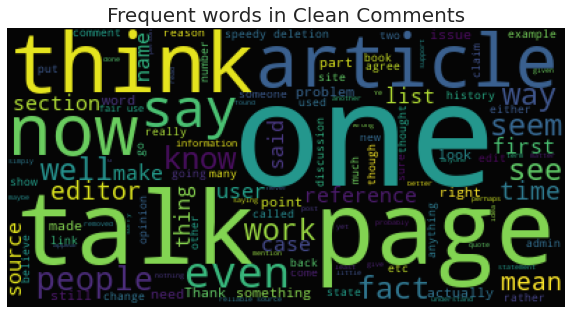

In [ ]:
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Frequent words in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()



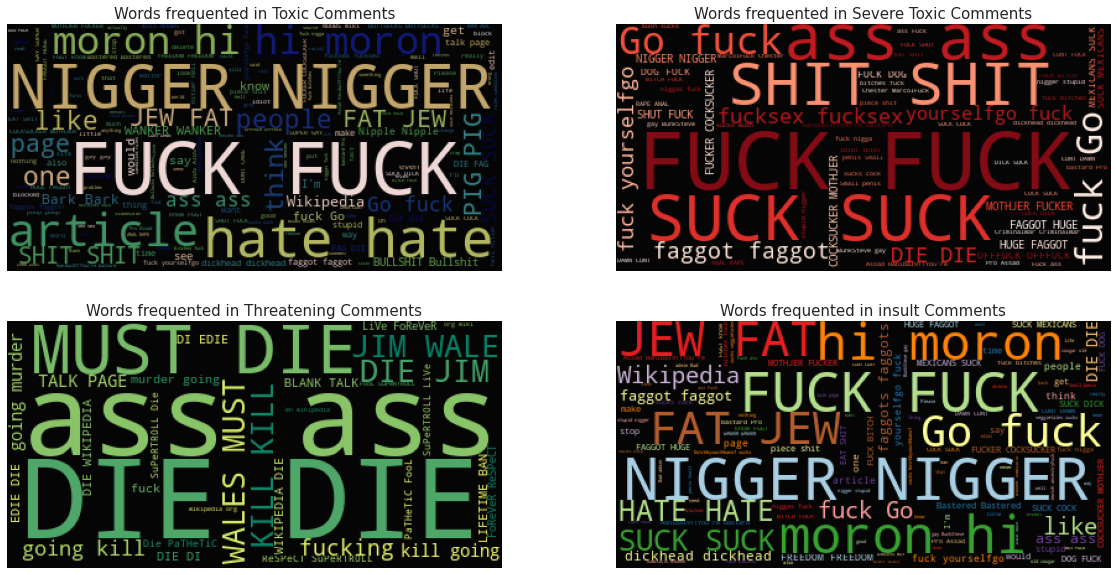

In [ ]:
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)

subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

In [ ]:
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

In [ ]:
df = train.iloc[:,0:2]
df['clean'] = train['clean']

,id,comment_text,clean
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",True
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,True
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",True
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,True
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",True


In [ ]:
## Indirect features

#Sentence count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [ ]:
train_feats=df

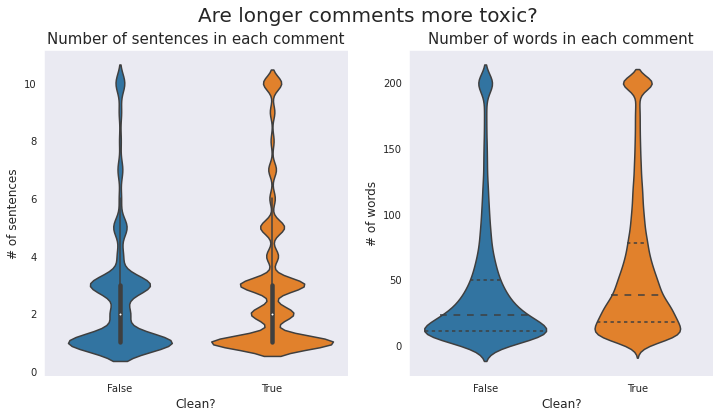

In [ ]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
np.random.seed(500)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,1


# Data Cleaning


In [ ]:
#Converting to lower
train["comment_text"] = train["comment_text"].apply(lambda x: x.lower())
display(train.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,none
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,True,1
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,True,1
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,True,1
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,True,1
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,True,1


In [ ]:
#Expanding the contractions:
# Intall the contractions package - https://github.com/kootenpv/contractions
!pip install contractions

In [ ]:
import contractions
train["comment_text"] = train["comment_text"].apply(lambda x: contractions.fix(x))


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,none
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,True,1
1,000103f0d9cfb60f,d'aww! he matches this background colour I am ...,0,0,0,0,0,0,True,1
2,000113f07ec002fd,"hey man, I am really not trying to edit war. i...",0,0,0,0,0,0,True,1
3,0001b41b1c6bb37e,"""\nmore\ni can not make any real suggestions o...",0,0,0,0,0,0,True,1
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,True,1


In [ ]:
#Removing the URLS
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [ ]:
train["comment_text"] = train["comment_text"].apply(lambda x: remove_URL(x))

In [ ]:
#remove html
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))
def remove_newline(text):
    return re.sub(r'\n', " ", text)


In [ ]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop = set(stopwords.words('english'))


In [ ]:
train = pd.read_csv('/content/drive/My Drive/train_token.csv')

In [ ]:
train.head()

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
train["comment_text"]=train["comment_text"].fillna('').astype(str)

In [ ]:
train["comment_text"] = train["comment_text"].apply(lambda x: remove_stopwords(x))

In [ ]:
train["comment_text"] = train["comment_text"].apply(lambda x: remove_html(x), lambda x: remove_non_ascii(x))

In [ ]:
train["comment_text"] = train["comment_text"].apply(lambda x: remove_punct(x), lambda x: other_clean(x))

In [ ]:
train["comment_text"] = train["comment_text"].apply(lambda x: remove_newline(x))

In [ ]:
def other_clean(text):
       
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "\n" : " ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Tokenizing the tweet base texts.

train['tokenized'] = train['comment_text'].apply(word_tokenize)

train.head()

In [ ]:
train = train.drop(labels=['clean'], axis=1)

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,tokenized
0,0000997932d777bf,explanation edits username hardcore metallica ...,0,0,0,0,0,0,1,"['explanation', 'why', 'the', 'edits', 'made',..."
1,000103f0d9cfb60f,daww matches background colour I seemingly stu...,0,0,0,0,0,0,1,"['daww', 'he', 'matches', 'this', 'background'..."
2,000113f07ec002fd,hey man I trying edit war guy constantly remov...,0,0,0,0,0,0,1,"['hey', 'man', 'I', 'am', 'really', 'not', 'tr..."
3,0001b41b1c6bb37e,real suggestions improvement wondered section ...,0,0,0,0,0,0,1,"['more', 'i', 'can', 'not', 'make', 'any', 're..."
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,1,"['you', 'sir', 'are', 'my', 'hero', 'any', 'ch..."


In [ ]:
train.to_csv('train_token.csv',index=False)

In [ ]:
train = pd.read_csv("train_token.csv")

In [ ]:
X = train.iloc[:,9:].values
y= train.iloc[:,2:9].values


In [ ]:
X

array([[list(['explanation', 'edits', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'remove', 'template', 'talk', 'page', 'I', 'retired', 'now892053827'])],
       [list(['daww', 'matches', 'background', 'colour', 'I', 'seemingly', 'stuck', 'thanks', 'talk', '2151', 'january', '11', '2016', 'utc'])],
       [list(['hey', 'man', 'I', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'talk', 'page', 'care', 'formatting', 'actual', 'info'])],
       ...,
       [list(['spitzer', 'umm', 'actual', 'article', 'prostitution', 'ring', 'crunch', 'captain'])],
       [list(['looks', 'like', 'actually', 'speedy', 'version', 'deleted', 'look'])],
       [list(['think', 'understand', 'came', 'idea', 'bad', 'right', 'away', 'kind', 'community', 'goes', 'bad', 'ideas', 'away', 'instead', 'helping', 'rewrite'])]],
      dtype=object)

In [ ]:
y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
#For splitting the dataset
!pip install scikit-multilearn


In [ ]:
from skmultilearn.model_selection import IterativeStratification
import skmultilearn

In [ ]:
X_train, y_train, X_test, y_test = skmultilearn.model_selection.iterative_stratification.iterative_train_test_split(X, y, test_size=0.2)

In [ ]:
X_train

array([[list(['explanation', 'edits', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'remove', 'template', 'talk', 'page', 'I', 'retired', 'now892053827'])],
       [list(['hey', 'man', 'I', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'talk', 'page', 'care', 'formatting', 'actual', 'info'])],
       [list(['sir', 'hero', 'chance', 'remember', 'page'])],
       ...,
       [list(['spitzer', 'umm', 'actual', 'article', 'prostitution', 'ring', 'crunch', 'captain'])],
       [list(['looks', 'like', 'actually', 'speedy', 'version', 'deleted', 'look'])],
       [list(['think', 'understand', 'came', 'idea', 'bad', 'right', 'away', 'kind', 'community', 'goes', 'bad', 'ideas', 'away', 'instead', 'helping', 'rewrite'])]],
      dtype=object)

In [ ]:
X_traindf = pd.DataFrame(data=X_train, index=None, columns=['comment_text'])


In [ ]:
y_traindf = pd.DataFrame(data=y_train, index=None, columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate','none'])

In [ ]:
X_testdf = pd.DataFrame(data=X_test, index=None, columns=['comment_text'])
y_testdf = pd.DataFrame(data=y_test, index=None, columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate','none'])

In [ ]:
X_traindf.to_csv('/content/drive/My Drive/toxic/Xtraindf.csv')
y_traindf.to_csv('/content/drive/My Drive/toxic/ytraindf.csv')
X_testdf.to_csv('/content/drive/My Drive/toxic/Xtestdf.csv')
y_testdf.to_csv('/content/drive/My Drive/toxic/ytestdf.csv')

NameError: ignored

# Data Transformation

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [ ]:
X_traindf = pd.read_csv('/content/drive/My Drive/toxic/Xtraindf.csv')
y_traindf=pd.read_csv('/content/drive/My Drive/toxic/ytraindf.csv')
X_testdf=pd.read_csv('/content/drive/My Drive/toxic/Xtestdf.csv')
y_testdf=pd.read_csv('/content/drive/My Drive/toxic/ytestdf.csv')

In [ ]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
train_text = X_traindf['comment_text']
test_text = X_testdf['comment_text']
all_text = pd.concat([train_text, test_text])

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])
scores = []

In [ ]:
#For generating a dataframe
final = pd.DataFrame.from_dict({'id': y_testdf['none']})

# Baseline model


In [ ]:
for class_name in class_names:
    train_target = y_traindf[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    final[class_name] = classifier.predict_proba(test_features)[:, 1]


CV score for class toxic is 0.9622985972564476
CV score for class severe_toxic is 0.9862278892453169
CV score for class obscene is 0.9853851640763188
CV score for class threat is 0.9749326071461434
CV score for class insult is 0.9735550798541129
CV score for class identity_hate is 0.9739291620528531


In [ ]:
final = final.drop(labels='id', axis=1)

In [ ]:
y_testdf=y_testdf.drop(labels='Unnamed: 0', axis=1)

In [ ]:
y2 = y_testdf[class_names].values

In [ ]:
final2 = final[class_names].values.round()

In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y2, final2)))
y_pred=final2
print('Micro Precision: {:.2f}'.format(precision_score(y2, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y2, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y2, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y2, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y2, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y2, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y2, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y2, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y2, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y2, y_pred, target_names=class_names))


Accuracy: 0.92

Micro Precision: 0.91
Micro Recall: 0.47
Micro F1-score: 0.62

Macro Precision: 0.68
Macro Recall: 0.30
Macro F1-score: 0.40

Weighted Precision: 0.89
Weighted Recall: 0.47
Weighted F1-score: 0.61

Classification Report

               precision    recall  f1-score   support

        toxic       0.96      0.51      0.67      3059
 severe_toxic       0.61      0.19      0.29       319
      obscene       0.94      0.57      0.71      1690
       threat       0.00      0.00      0.00        96
       insult       0.82      0.44      0.57      1575
identity_hate       0.74      0.08      0.15       281

    micro avg       0.91      0.47      0.62      7020
    macro avg       0.68      0.30      0.40      7020
 weighted avg       0.89      0.47      0.61      7020
  samples avg       0.05      0.04      0.04      7020



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bidirectional LSTM


In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
# path = '/content/drive/My Drive/toxic'
# comp = 'jigsaw-toxic-comment-classification-challenge/'
# EMBEDDING_FILE=f'{path}glove6b50d/glove.6B.50d.txt'
# TRAIN_DATA_FILE=f'{path}{comp}train.csv'
# TEST_DATA_FILE=f'{path}{comp}test.csv'

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [ ]:
Xtrain = pd.read_csv("/content/drive/My Drive/toxic/Xtraindf.csv")
Xtest = pd.read_csv('/content/drive/My Drive/toxic/Xtestdf.csv')
ytrain = pd.read_csv('/content/drive/My Drive/toxic/ytraindf.csv')
ytest = pd.read_csv('/content/drive/My Drive/toxic/ytestdf.csv')


list_sentences_train = Xtrain["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = ytrain[list_classes].values
list_sentences_test = Xtest["comment_text"].fillna("_na_").values
y2 = ytest[list_classes].values

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('/content/drive/My Drive/toxic/glove.6B.50d.txt'))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.020940498, 0.6441043)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)

In [ ]:
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)

In [ ]:
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)

In [ ]:
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

In [ ]:
history = model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
3591/3591 [==============================] - 887s 247ms/step - loss: 0.0775 - accuracy: 0.9477 - val_loss: 0.0587 - val_accuracy: 0.9940
Epoch 2/2
3591/3591 [==============================] - 893s 249ms/step - loss: 0.0505 - accuracy: 0.9920 - val_loss: 0.0539 - val_accuracy: 0.9940


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


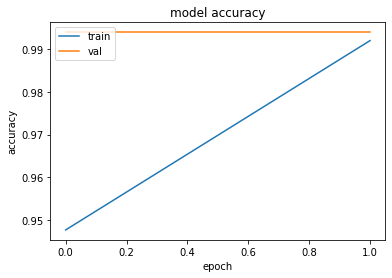

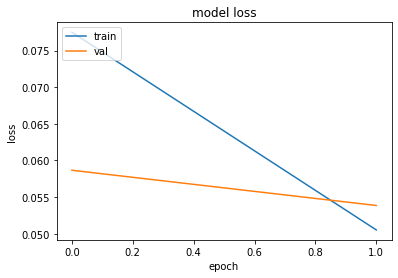

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Save the Weights
model.save_weights("Abuse_bidirec.h5")

In [ ]:
y_pred = model.predict(X_te)

In [ ]:
y_pred = y_pred.round()

In [ ]:
y_pred 

In [ ]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y2.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
multilabel_confusion_matrix(y2, y_pred, samplewise=False )

# Model Evaluation


In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y2, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y2, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y2, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y2, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y2, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y2, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y2, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y2, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y2, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y2, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y2, y_pred, target_names=list_classes))



Accuracy: 0.92

Micro Precision: 0.81
Micro Recall: 0.64
Micro F1-score: 0.72

Macro Precision: 0.64
Macro Recall: 0.40
Macro F1-score: 0.45

Weighted Precision: 0.80
Weighted Recall: 0.64
Weighted F1-score: 0.70

Classification Report

               precision    recall  f1-score   support

        toxic       0.85      0.72      0.78      3059
 severe_toxic       0.56      0.24      0.34       319
      obscene       0.86      0.72      0.79      1690
       threat       0.00      0.00      0.00        96
       insult       0.72      0.64      0.67      1575
identity_hate       0.88      0.05      0.10       281

    micro avg       0.81      0.64      0.72      7020
    macro avg       0.64      0.40      0.45      7020
 weighted avg       0.80      0.64      0.70      7020
  samples avg       0.06      0.06      0.06      7020



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: 